# **Applying MLP on a Synthetic Dataset**

## **Author Details**

**R Anirudh**     (1MS17IS084)

**Rohit P N**     (1MS17IS094)

**Snehil Tiwari** (1MS17IS153)

**Institute: Ramaiah Institite of Technology, Bangalore**

**Date of submission: 07 May 2020**

## **Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

%matplotlib inline

## **Synthesizing a Binary Classification Dataset Based on the Given Requirements**

This function used here uses multiple randomized gaussians to sample data from, with a bunch of gaussians belonging to 1 class, in this case 2, which is the default.

Thus, the data is sampled from 4 gaussians, each pair belonging to 1 class.

In [2]:
# No. of data points
n_samples = 200

# No. of features (dimensions of the data)
n_features = 5

# No. of redundent features (linear combinations of other features)
n_redundant = 1

# No. of classes
n_classes = 2

X, y = make_classification(n_samples=n_samples, n_features=n_features,
                            n_redundant=n_redundant, n_classes=n_classes, random_state=2)

In [3]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [4]:
X.shape, y.shape

((200, 5), (200,))

In [5]:
# Creating a dataframe out of it
df = pd.DataFrame(X, columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5'])

In [6]:
df['label'] = y

In [7]:
df.head()

,feature1,feature2,feature3,feature4,feature5,label
0,0.936527,1.254761,0.562705,-0.582071,-0.481708,1
1,1.145608,1.765397,2.162462,0.657551,0.457231,1
2,0.660337,0.714834,-0.154410,-1.749289,-1.110911,1
3,1.017696,1.596107,0.702014,-0.356136,0.532495,1
4,-1.734575,-2.284095,-0.649205,-2.428253,1.073290,0


##### **Lets visualize our data before proceeding**

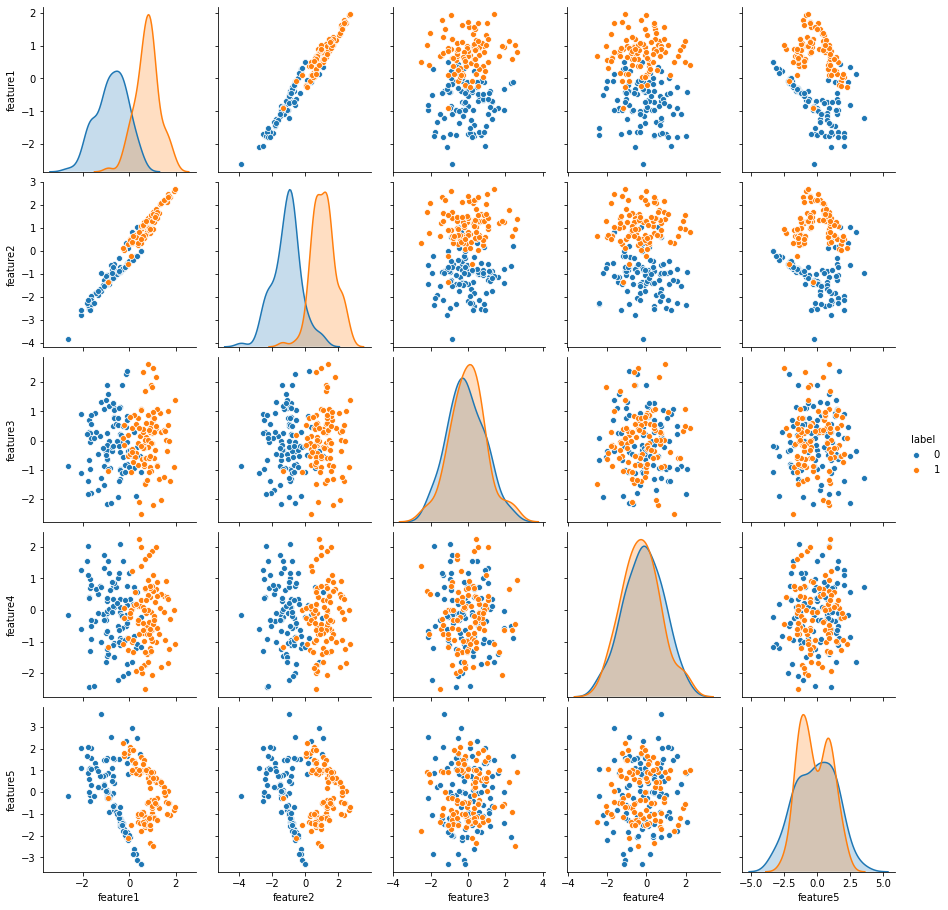

In [8]:
sns.pairplot(df, hue="label")

There's a decent amount of linear seperability in features 1 & 2 and the data follows gaussian distribution.

Thus, a simple single layer perceptron would be able to classify this data pretty easily,
but we implement a more complex multilayer perceptron in this notebook, just to get a deeper understanding of its working.

In [9]:
df.to_csv('./data/synthetic.csv', index=False)

## **Data Preparation**

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=0) # random state to ensure same results in every run

## **MLP From Scratch**

### **Architecture**

In [11]:
architecture = [
    {'input_dim': 5, 'output_dim': 7, 'activation': 'relu'},    # Input layer, input_dim=5 for the 5 features we have in our X data
    {'input_dim': 7, 'output_dim': 7, 'activation': 'relu'},    # Hidden layer, with 7 neurons, this will take the data to a 7 dimensional space, but even a 3D would work here
    {'input_dim': 7, 'output_dim': 1, 'activation': 'sigmoid'}  # Output layer, output_dim=1, which will represent 0 or 1 for the 2 classes we have.
]

This is a very complex network for the simple linearly seperable data we have, but
it should work just fine.

Though the hidden layer can be removed without any effect on performance.

### **Initializing Layers**

In [12]:
def init_layers(architecture):
    no_of_layers = len(architecture)
    params = {}
    
    for index, layer in enumerate(architecture):
        layer_index = index + 1
        layer_input_size = layer['input_dim']
        layer_output_size = layer['output_dim']
        
        params['W' + str(layer_index)] = np.random.randn(layer_output_size,
                                                               layer_input_size) * 0.1
        params['b' + str(layer_index)] = np.random.randn(layer_output_size, 1) * 0.1
        
    return params

### **Activation Functions**

#### **Sigmoid**

![Sigmoid](images/sigmoid.png)

This will be used at the output layer to squish the outputs between 0 and 1

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#### **Derivative of Sigmoid**

![Sigmoid Derivative](images/sigmoid_derivative.png)

This will be used during backpropogation for find the derivative of the activations

In [14]:
def sigmoid_derivative(dA, x):
    """
    dA is the derivatives of the activation in the current layer
    """
    sig = sigmoid(x)
    return dA * sig * (1 - sig)

#### **RelU**

![RelU](images/relu.png)

We use RelU as our activation in the input and hidden layers, as it helps speed up the training and is known to work well

In [15]:
def relu(x):
    return np.maximum(0, x)

#### **RelU Derivative**

![RelU Derivative](images/relu_derivative.png)

Again, used to find the derivative during backpropogation

In [16]:
def relu_derivative(dA, x):
    dZ = np.array(dA, copy=True)
    dZ[x <= 0] = 0
    return dZ

### **Forward Propogation**

#### **Single Layer Forward Propogation**

In [17]:
def single_layer_forward_propogation(A_prev, W_curr, b_curr, activation="relu"):
    
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == 'relu':
        activation_function = relu
        
    elif activation == 'sigmoid':
        activation_function = sigmoid
        
    A_curr = activation_function(Z_curr)
    
    return A_curr, Z_curr

#### **Combined forward propogation**

In [18]:
def forward_propogation(X, params, architecture):
    
    memory = {}
    A_curr = X
    
    for index, layer in enumerate(architecture):
        layer_index = index + 1
        A_prev = A_curr
        
        current_activation_function = layer['activation']
        
        W_curr = params['W' + str(layer_index)]
        b_curr = params['b' + str(layer_index)]
        
        A_curr, Z_curr = single_layer_forward_propogation(A_prev, W_curr, b_curr, current_activation_function)
        
        memory['A' + str(index)] = A_prev
        memory['Z' + str(layer_index)] = Z_curr
        
    return A_curr, memory

### **Loss Function**

In [19]:
def loss_function(y_hat, y):
    """
    This function implements a log loss between 2 distribution samples
    Log loss gives a measure of the difference between 2 probability distributions, as we are trying to estimate the probability distribution of y here,
    we get a measure of how far y_hat is from y.
    """
    m = y_hat.shape[1]
    loss = -(1 / m) * (np.dot(y, np.log(y_hat).T) + np.dot(1-y, np.log(1-y_hat).T))
    return np.squeeze(loss)

### **Accuracy Function**

In [20]:
def accuracy_function(y_hat, y):
    """
    We implement a simple function that checks how many classifications were made correctly, and calculate accuracy based on that
    """
    y_hat = np.round(y_hat)
    return (y_hat == y).all(axis=0).mean()

### **Single Layer Backpropogation**

In [21]:
def single_layer_backpropogation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation='relu'):
    """
    dA_curr: derivatives of current layer's activation values
    w_curr: current layer's weights
    b_curr: current layer's biases
    Z_curr: current layer's calculations without activation applied
    A_prev: previous layer's activation values
    """
    
    m = A_prev.shape[1]
    
    if activation == 'relu':
        backward_activation_function = relu_derivative
        
    elif activation == 'sigmoid':
        backward_activation_function = sigmoid_derivative
        
    dZ_curr = backward_activation_function(dA_curr, Z_curr)
    
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr

### **BackPropogation**

In [22]:
def backpropogation(y_hat, y, memory, params, architecture):
    """
    y_hat: predictions
    y: true values
    memory: Current forward propogation's activations and calculations
    params: Weights and biases of the network
    architecture: architecture of the network
    """
    
    gradients = {}
    y = y.reshape(y_hat.shape)
    
    dA_prev = -(np.divide(y, y_hat) - np.divide(1-y, 1-y_hat))
    
    for layer_index_prev, layer in reversed(list(enumerate(architecture))):
        layer_index_curr = layer_index_prev + 1
        
        activation_function_current = layer['activation']
        dA_curr = dA_prev
        
        A_prev = memory['A' + str(layer_index_prev)]
        Z_curr = memory['Z' + str(layer_index_curr)]
        W_curr = params['W' + str(layer_index_curr)]
        b_curr = params['b' + str(layer_index_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backpropogation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation_function_current)
        
        gradients['dW' + str(layer_index_curr)] = dW_curr
        gradients['db' + str(layer_index_curr)] = db_curr
        
    return gradients

### **Updating the trainable parameters**

In [23]:
def update(params, gradients, architecture, lr):
    """
    This is the standard Gradient Descent step
    """
    for index, layer in enumerate(architecture):
        index += 1
        
        params['W' + str(index)] -= lr * gradients['dW' + str(index)]
        params['b' + str(index)] -= lr * gradients['db' + str(index)]
        
    return params

## **Training**

### **Validation Function**

In [24]:
def valid(X, y, params, architecture):
   
    y_hat, _ = forward_propogation(X, params, architecture)        
    loss = loss_function(y_hat, y)
    accuracy = accuracy_function(y_hat, y)
        
    return loss, accuracy

### **Training Function**

In [25]:
def train(X, y, architecture, epochs, lr, valid_data):
    params = init_layers(architecture)
    
    train_loss_history = []
    train_accuracy_history = []
    
    valid_loss_history = []
    valid_accuracy_history = []
    
    X_valid = valid_data[0].T
    y_valid = valid_data[1]
    
    for i in range(epochs):
        y_hat, memory = forward_propogation(X, params, architecture)        
        loss = loss_function(y_hat, y)
        accuracy = accuracy_function(y_hat, y)
        
        if i % (epochs/10) == 0:
            
            train_loss_history.append(loss)
            train_accuracy_history.append(accuracy)
            
            print('---------- EPOCH %d -------------' %i)
            print('Training accuracy: %.3f' %accuracy)
            print('Training loss: %.3f' %loss)
            
            valid_loss, valid_acc = valid(X_valid, y_valid, params, architecture)
            
            print("\nValidation accuracy: %.3f" %valid_acc)
            print("Validation loss: %.3f\n\n" %valid_loss)
            
            valid_loss_history.append(valid_loss)
            valid_accuracy_history.append(valid_acc)
        
        gradients = backpropogation(y_hat, y, memory, params, architecture)
        params = update(params, gradients, architecture, lr)

    print("---------------- FINAL RESULTS ------------------")
    
    print('Final training accuracy: %.3f' %accuracy)
    print('Final training loss: %.3f' %loss)
    
    valid_loss, valid_acc = valid(X_valid, y_valid, params, architecture)
    
    print("\nFinal validation accuracy: %.3f" %valid_acc)
    print("Final validation loss: %.3f" %valid_loss)
        
    return params, (train_accuracy_history, valid_accuracy_history), (train_loss_history, valid_loss_history)

### **Training Time!**

In [26]:
learning_rate = 3e-2
epochs = 10000
params, accuracy_history, loss_history = train(X_train.T, y_train, architecture, epochs, learning_rate, valid_data=(X_valid, y_valid))

---------- EPOCH 0 -------------
Training accuracy: 0.480
Training loss: 0.701

Validation accuracy: 0.540
Validation loss: 0.690


---------- EPOCH 1000 -------------
Training accuracy: 0.920
Training loss: 0.190

Validation accuracy: 0.960
Validation loss: 0.112


---------- EPOCH 2000 -------------
Training accuracy: 0.927
Training loss: 0.162

Validation accuracy: 0.960
Validation loss: 0.107


---------- EPOCH 3000 -------------
Training accuracy: 0.933
Training loss: 0.141

Validation accuracy: 0.940
Validation loss: 0.110


---------- EPOCH 4000 -------------
Training accuracy: 0.940
Training loss: 0.132

Validation accuracy: 0.940
Validation loss: 0.108


---------- EPOCH 5000 -------------
Training accuracy: 0.940
Training loss: 0.126

Validation accuracy: 0.940
Validation loss: 0.105


---------- EPOCH 6000 -------------
Training accuracy: 0.947
Training loss: 0.119

Validation accuracy: 0.960
Validation loss: 0.101


---------- EPOCH 7000 -------------
Training accuracy: 0.9

**So a final validation accuracy of 96%, not bad!**

Though it took 10000 epochs. The same accuracies could have been achieved much faster using momentum in our optimizer.

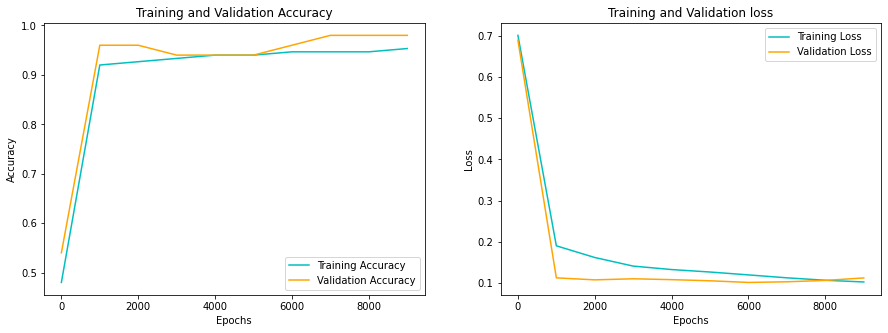

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].plot(range(0, epochs, int(epochs/10)), accuracy_history[0], 'c', label='Training Accuracy')
axes[0].plot(range(0, epochs, int(epochs/10)), accuracy_history[1], 'orange', label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[1].plot(range(0, epochs, int(epochs/10)), loss_history[0], 'c', label='Training Loss')
axes[1].plot(range(0, epochs, int(epochs/10)), loss_history[1], 'orange', label='Validation Loss')
axes[1].set_title('Training and Validation loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

### **Learnt Weights and Hyperparams**

In [28]:
print('Learing rate  : ', learning_rate)
print('Epochs        : ', epochs)

Learing rate  :  0.03
Epochs        :  10000


In [29]:
print('Learnt parameters: \n', params)

Learnt parameters: 
 {'W1': array([[-0.03816455, -0.09113537,  0.36785377, -0.66232146,  0.08337898],
       [-0.51743315, -0.5920745 ,  0.60777846, -0.01289531, -0.64983108],
       [ 0.28306129,  0.04355387,  0.02354817, -0.15639294,  0.15305815],
       [-0.05748954,  0.12557297,  0.05772496,  0.44746987,  0.7785296 ],
       [ 0.20089318, -0.00282817, -0.1247107 , -0.01083306, -0.02209953],
       [-0.24644715, -0.2755032 , -0.55745944,  0.13898241, -0.57898717],
       [ 0.0550409 ,  0.124419  ,  0.44018096,  0.04354136, -0.30030897]]), 'b1': array([[-0.53156701],
       [ 1.11381941],
       [-0.15266565],
       [ 0.91500518],
       [-0.12106078],
       [-1.16999519],
       [ 1.57836481]]), 'W2': array([[-3.48495375e-02,  1.54877804e-01,  7.73090313e-02,
         5.90391707e-02, -7.27459144e-02, -2.31682475e-02,
         1.61054356e-03],
       [ 6.83425282e-01,  8.00353869e-01, -1.22080998e-01,
         1.20187303e+00, -1.44656837e-01,  1.23851640e+00,
        -3.67295836e-0

### **Prediction Function**

In [30]:
def predict(X_sample, params=params, architecture=architecture):
    y_hat, memory = forward_propogation(X_sample, params, architecture)
    return np.round(y_hat)

### **Predicting a Sample**

In [31]:
X_sample = X_valid[1].reshape(1,-1).T
y_sample = y_valid[1]

y_pred = predict(X_sample)

print("Data point        : ", X_sample.reshape(-1))
print("True y value      : ", y_sample)
print("Predicted y value : ", y_pred.reshape(-1))

Data point        :  [-0.63376845 -0.58377539  1.05763457  0.84236934  1.53062533]
True y value      :  0
Predicted y value :  [0.]


## **Classification Report**

We'll be creating the classification report for our validation dataset

In [32]:
X_valid.shape, y_valid.shape

((50, 5), (50,))

In [33]:
y_pred = predict(X_valid.T)
y_pred = y_pred.reshape(-1)

In [34]:
def report(y_true, y_pred):
    
    target_labels = ['class_0', 'class_1']
    
    classificationReport = classification_report(y_true, y_pred, target_names=target_labels)
    confusionMatrix = confusion_matrix(y_true, y_pred)
    oa = accuracy_score(y_true, y_pred)
    
    print('\n\n------------------------ OVERALL ACCURACY -------------------------')
    print(oa)
    
    print("\n\n---------------------- CLASSIFICATION REPORT ----------------------")
    print(classificationReport)
    
    print("\n\n------------------------ CONFUSION MATRIX -------------------------")
    print(confusionMatrix)
    sns.heatmap(confusionMatrix, annot=True,cmap="RdPu", xticklabels=['true_0', 'true_1'], yticklabels=['pred_0', 'pred_1'])



------------------------ OVERALL ACCURACY -------------------------
0.96


---------------------- CLASSIFICATION REPORT ----------------------
              precision    recall  f1-score   support

     class_0       0.96      0.96      0.96        27
     class_1       0.96      0.96      0.96        23

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



------------------------ CONFUSION MATRIX -------------------------
[[26  1]
 [ 1 22]]


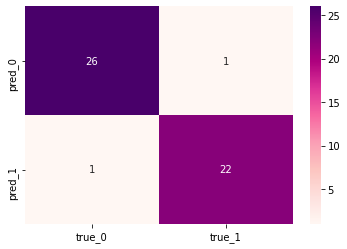

In [35]:
report(y_valid, y_pred)